## Llama Exporting 1

- Ok need to figure out exactly what to export here - there's a lot of ways to project all this information on to the animation
- Starting on my linux machine then will need to move to runpod I think when I get into gradients. 

In [1]:
import torch
from transformers import pipeline
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

from transformers import LlamaForCausalLM, PreTrainedTokenizerFast, LlamaConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

device='cuda'

In [2]:
from transformer_lens import ActivationCache, HookedTransformer, utils
from transformer_lens.hook_points import HookPoint
import einops

In [3]:
baby_dataset_so_cute=[
    #jibberish
    "as dflkja sdf",
    "18 9sdfsf 8sdf8sns",
    "as dfasdf uowo fof",
    
    # Arithmetic (10 examples)
    "2 + 2 = 4",
    "4 + 3 = 7",
    "2 + 9 = 11",
    "11 - 10 = 1",
    "3 - 6 = -3",  # Gets this one wrong
    "3 * 6 = 18",
    "3 * 2 = 6",
    "8 / 2 = 4",
    "128 / 32 = 4",
    "9 * 7 = 63",
    
    # Geography facts (8 examples)
    "The capital of France is Paris",
    "The capital of Japan is Tokyo",
    "The capital of Brazil is Brasília",
    "Mount Everest is located in the Himalayas",
    "The Amazon River flows through South America",
    "The largest continent is Asia",
    "The Pacific Ocean borders Asia, Australia, North America, and South America",
    "The currency of China is the yuan",
    
    # Sports facts (8 examples)
    "The Lakers play in Los Angeles",
    "The World Cup is held every 4 years",
    "Serena Williams plays tennis",
    "The Super Bowl happens in February",
    "A basketball team has 5 players on the court",
    "The Olympics occur every 2 years",
    "Tiger Woods is famous for golf",
    "Cristiano Ronaldo plays soccer",
    
    # Code
    "def add_numbers(a, b):",
    "import numpy as np",
    "for i in range(",
    "if x > 0:",
    "print('Hello')",
    "class Dog:",
    "return x + y",
    "from datetime import datetime",
    "x = [1, 2, 3",
    
    # Creative writing (10 examples)
    "Once upon a time, in a magical forest",
    "The old wizard looked up at the stars and",
    "She opened the mysterious door and found",
    "The dragon's eyes glowed softly as",
    "In the bustling marketplace, children",
    "As the sun set behind the mountains,",
    "The little robot whirred to life and",
    "Deep in the ocean, a mermaid",
    "The spaceship landed with a gentle",
    "Through the mist came the sound of",

    # Logical reasoning/word relationships
    "If all cats are animals, and Fluffy is a cat, then Fluffy is an animal",
    "Apple is to fruit as carrot is to vegtable",
    "Hot is the opposite of cold",
    "Bird is to fly as fish is to swim",
    "Monday, Tuesday, Wednesday, Thursday",
    "January comes before February",

    #Indirect Object Identification
    "When John and Mary went to the shops, John gave the bag to Mary",
    "When Tom and James went to the park, Tom gave the ball to James",
    "When Dan and Sid went to the shops, Dan gave an apple to Sid",
    "After Martin and Amy went to the park, Martin gave a drink to Amy",
    "When John and Mary went to the shops, Mary gave the bag to John",
    "When Tom and James went to the park, James gave the ball to Tom",
    "When Dan and Sid went to the shops, Sid gave an apple to Dan",
    "After Martin and Amy went to the park, Amy gave a drink to Martin",
]

In [4]:
model_id = "meta-llama/Llama-3.2-1B"

# model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
model = HookedTransformer.from_pretrained(model_id, device=device) #Transfomer lens version
tokenizer = AutoTokenizer.from_pretrained(model_id)

Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer


In [5]:
prompt = "The captial of France is"
answer = " Paris"
utils.test_prompt(prompt, answer, model)

Tokenized prompt: ['<|begin_of_text|>', 'The', ' capt', 'ial', ' of', ' France', ' is']
Tokenized answer: [' Paris']


Performance on answer token:
Rank: 0        Logit: 16.94 Prob: 34.99% Token: | Paris|

Top 0th token. Logit: 16.94 Prob: 34.99% Token: | Paris|
Top 1th token. Logit: 15.24 Prob:  6.42% Token: | the|
Top 2th token. Logit: 14.96 Prob:  4.83% Token: | a|
Top 3th token. Logit: 14.47 Prob:  2.97% Token: | also|
Top 4th token. Logit: 14.23 Prob:  2.34% Token: | located|
Top 5th token. Logit: 14.08 Prob:  2.01% Token: | known|
Top 6th token. Logit: 14.03 Prob:  1.92% Token: | not|
Top 7th token. Logit: 13.73 Prob:  1.42% Token: | in|
Top 8th token. Logit: 13.68 Prob:  1.35% Token: | situated|
Top 9th token. Logit: 13.56 Prob:  1.20% Token: | called|


Ranks of the answer tokens: [(' Paris', 0)]

In [6]:
inputs = tokenizer("The captial of France is", return_tensors="pt").to(device)
input_ids = inputs["input_ids"]

logits, cache = model.run_with_cache(input_ids)

In [7]:
keys = [k for k in cache.keys() if 'blocks.3' in k]

In [8]:
keys

['blocks.3.hook_resid_pre',
 'blocks.3.ln1.hook_scale',
 'blocks.3.ln1.hook_normalized',
 'blocks.3.attn.hook_q',
 'blocks.3.attn.hook_k',
 'blocks.3.attn.hook_v',
 'blocks.3.attn.hook_rot_q',
 'blocks.3.attn.hook_rot_k',
 'blocks.3.attn.hook_attn_scores',
 'blocks.3.attn.hook_pattern',
 'blocks.3.attn.hook_z',
 'blocks.3.hook_attn_out',
 'blocks.3.hook_resid_mid',
 'blocks.3.ln2.hook_scale',
 'blocks.3.ln2.hook_normalized',
 'blocks.3.mlp.hook_pre',
 'blocks.3.mlp.hook_pre_linear',
 'blocks.3.mlp.hook_post',
 'blocks.3.hook_mlp_out',
 'blocks.3.hook_resid_post']

In [9]:
cache['blocks.3.hook_resid_mid'].shape

torch.Size([1, 7, 2048])

In [10]:
cache['blocks.3.mlp.hook_pre'].shape

torch.Size([1, 7, 8192])

In [11]:
cache['blocks.3.mlp.hook_pre_linear'].shape

torch.Size([1, 7, 8192])

In [12]:
cache['blocks.3.mlp.hook_post'].shape

torch.Size([1, 7, 8192])

In [13]:
cache['blocks.3.hook_mlp_out'].shape

torch.Size([1, 7, 2048])

- Ok so I need to decide which of the 7 positions to show, that's a bit tricky, let's try the last position!
- I think the caches I want are: `blocks.3.hook_resid_mid`, `blocks.3.mlp.hook_post`, and `blocks.3.hook_mlp_out'`
- This is just for activations, so downsampling should be actually pretty easy I think?

In [14]:
cache['blocks.3.hook_resid_mid'][:,-1].unsqueeze(0).shape

torch.Size([1, 1, 2048])

In [15]:
torch.nn.MaxPool1d(kernel_size=2, stride=2)(torch.tensor([[[1.,2,3,4,5,6,7,8,9,10]]]))

tensor([[[ 2.,  4.,  6.,  8., 10.]]])

In [16]:
torch.nn.MaxPool1d(kernel_size=64, stride=64)(cache['blocks.3.hook_resid_mid'][:,-1].unsqueeze(0)).shape

torch.Size([1, 1, 32])

In [17]:
cache['blocks.3.mlp.hook_post'][:,-1].unsqueeze(0).shape

torch.Size([1, 1, 8192])

In [18]:
torch.nn.MaxPool1d(kernel_size=240, stride=240)(cache['blocks.3.mlp.hook_post'][:,-1].unsqueeze(0)).shape

torch.Size([1, 1, 34])

In [19]:
save_dir='/home/stephen/backprop2/may_31_1'

In [20]:
for layer_num in range(16):
    # print(cache['blocks.'+str(layer_num)+'.hook_resid_mid'][:,-1].unsqueeze(0).shape)
    cache_name='blocks.'+str(layer_num)+'.hook_resid_mid'
    a=torch.nn.MaxPool1d(kernel_size=64, stride=64)(cache[cache_name][:,-1].unsqueeze(0)).cpu().ravel().numpy()
    np.save(save_dir+'/'+cache_name, a)

    cache_name='blocks.'+str(layer_num)+'.mlp.hook_post'
    a= torch.nn.MaxPool1d(kernel_size=240, stride=240)(cache[cache_name][:,-1].unsqueeze(0)).cpu().ravel().numpy()
    np.save(save_dir+'/'+cache_name, a)

    cache_name='blocks.'+str(layer_num)+'.hook_mlp_out'
    a= torch.nn.MaxPool1d(kernel_size=64, stride=64)(cache[cache_name][:,-1].unsqueeze(0)).cpu().ravel().numpy()
    np.save(save_dir+'/'+cache_name, a)

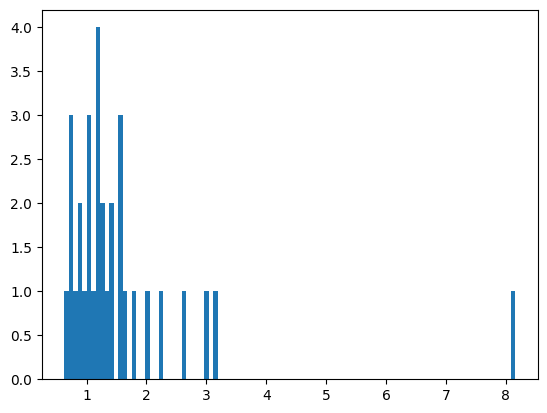

In [21]:
plt.hist(a.ravel(), 100);

- Ok I think that should be good for activations for now -> I can come back and add input and output stuff later - that will be cool!
- Ok now how should I pool down weights? 

In [22]:
model.blocks[0].mlp

GatedMLP(
  (hook_pre): HookPoint()
  (hook_pre_linear): HookPoint()
  (hook_post): HookPoint()
)

In [23]:
all_params={n:v for n,v in model.named_parameters()}

In [24]:
all_params['blocks.0.mlp.W_in'].detach().cpu().numpy().shape

(2048, 8192)

In [25]:
all_params['blocks.0.mlp.W_out'].detach().cpu().numpy().shape

(8192, 2048)

Ok cool so I need to get these puppies down to 32x34 and 34x32

In [26]:
torch.nn.MaxPool2d(kernel_size=(64,240), stride=(64,240))(all_params['blocks.0.mlp.W_in'].detach().cpu().unsqueeze(0)).numpy().shape

(1, 32, 34)

In [27]:
torch.nn.MaxPool2d(kernel_size=(240,64), stride=(240,64))(all_params['blocks.0.mlp.W_out'].detach().cpu().unsqueeze(0)).numpy().shape

(1, 34, 32)

In [28]:
all_params['blocks.0.mlp.W_in'].detach().cpu().unsqueeze(0).numpy().shape

(1, 2048, 8192)

In [29]:
for layer_num in range(16):
    param_name='blocks.'+str(layer_num)+'.mlp.W_in'
    a=torch.nn.MaxPool2d(kernel_size=(64,240), stride=(64,240))(all_params[param_name].detach().cpu().unsqueeze(0)).numpy()
    np.save(save_dir+'/'+param_name, a[0])

    param_name='blocks.'+str(layer_num)+'.mlp.W_out'
    a=torch.nn.MaxPool2d(kernel_size=(240, 64), stride=(240, 64))(all_params[param_name].detach().cpu().unsqueeze(0)).numpy()
    np.save(save_dir+'/'+param_name, a[0])

```
rsync -auv stephen@dev-3:/home/stephen/backprop2/may_31_1 .
```

- Ok, now the most hand-wavy thing I have to figure out here is what weights and grads to show between the mlp and attention layers.
- Can i figure something out that might have a chance at giving us a feel for the significance of each attenttion pattern?

In [30]:
for k in ['blocks.3.attn.W_Q', 'blocks.3.attn.W_O', 'blocks.3.attn.b_Q', 'blocks.3.attn.b_O', 
          'blocks.3.attn._W_K', 'blocks.3.attn._W_V', 'blocks.3.attn._b_K', 'blocks.3.attn._b_V']:
    print(k, all_params[k].shape)

blocks.3.attn.W_Q torch.Size([32, 2048, 64])
blocks.3.attn.W_O torch.Size([32, 64, 2048])
blocks.3.attn.b_Q torch.Size([32, 64])
blocks.3.attn.b_O torch.Size([2048])
blocks.3.attn._W_K torch.Size([8, 2048, 64])
blocks.3.attn._W_V torch.Size([8, 2048, 64])
blocks.3.attn._b_K torch.Size([8, 64])
blocks.3.attn._b_V torch.Size([8, 64])


- Hmm for inputs I'm kinda wondering about keys and queries together somehow?
- And for ourtput W_0 is the obvoius choice
- How do i preserve cardinality with the attention patterns though?
- Hmm I guess I should think about which attention patterns to show -> I'm going to show 10 I think
- Oh I guess the queries and ouputs are broken down by attention head, that's nice!
- Ok let's assume we're going to export all 32 patters and corresponding weights, and decide which ones to shot at render time.
- A simple and maybe not insane idea would be to just show queries.
- We could get crazy and have 3 connection points per attention pattern and show keys, queries, and values.
- Let's start simple with just queries and see how it goes -> it's definitely a pretty big simplification!

In [31]:
param_name='blocks.'+str(layer_num)+'.attn.W_Q'
torch.nn.MaxPool2d(kernel_size=(64,64), stride=(64,64))(all_params[param_name].detach().cpu()).numpy().shape

(32, 32, 1)

In [32]:
param_name='blocks.'+str(layer_num)+'.attn.W_O'
torch.nn.MaxPool2d(kernel_size=(64,64), stride=(64,64))(all_params[param_name].detach().cpu()).numpy().shape

(32, 1, 32)

In [33]:
for layer_num in range(16):
    param_name='blocks.'+str(layer_num)+'.attn.W_Q'
    a= torch.nn.MaxPool2d(kernel_size=(64,64), stride=(64,64))(all_params[param_name].detach().cpu()).numpy()
    np.save(save_dir+'/'+param_name, a[0])

    param_name='blocks.'+str(layer_num)+'.attn.W_O'
    a = torch.nn.MaxPool2d(kernel_size=(64,64), stride=(64,64))(all_params[param_name].detach().cpu()).numpy()
    np.save(save_dir+'/'+param_name, a[0])

Ok dope, let me look at saving attention patterns now!

In [34]:
a=cache['blocks.3.attn.hook_attn_scores'].detach().cpu().numpy()

In [35]:
a.shape

(1, 32, 7, 7)

In [36]:
for layer_num in range(16):
    # print(cache['blocks.'+str(layer_num)+'.hook_resid_mid'][:,-1].unsqueeze(0).shape)
    cache_name='blocks.'+str(layer_num)+'.attn.hook_attn_scores'
    a=cache[cache_name].detach().cpu().numpy()
    np.save(save_dir+'/'+cache_name, a)


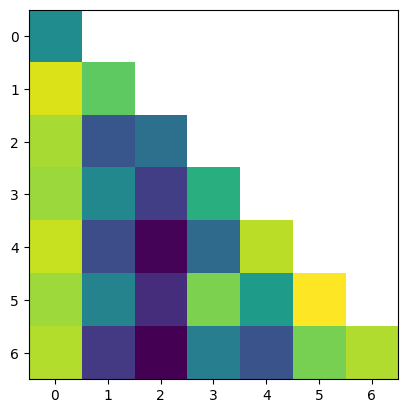

In [37]:
plt.imshow(a[0,0])

In [38]:
# all_params.keys()